# Purpose:
### Run every algorithm + filter over the data, find the one that maximizes precision

## Imports

In [1]:
import numpy as np # need this for basically everything
import matplotlib.pyplot as plt # plotting
import numba as nb # numba compiles to fast c code
from numba import jit
import scipy; from scipy import signal # savitzky-golay filter
import time # time results
# use cartesian product to make nested for loops its own iterator
#  I know it's janky, but it enables fast parallelism 
from itertools import product  
from multiprocess import Pool # parallelism
import pickle
from matplotlib.patches import Ellipse

In [2]:
wavelen = 3500
%load_ext Cython

In [3]:
plt.rcParams.update({'font.size': 24})

### Waveform Generation

In [4]:
@jit(nopython=True)
def dataGen(amp, T0):
    wf = np.empty(3500)
    length = len(wf)
    cc_slow = 2.5+0.4*np.random.normal(); cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant

    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=np.zeros(2);charge=np.zeros(2);cur_s=np.zeros(2);cur_f=np.zeros(2);cr=np.zeros(2);rc1=np.zeros(2);rc2=np.zeros(2);
    for i in range(length):
        if i>=T0:
            step[i%2]=1.
        else:
            step[i%2]=0.
        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        wf[i]=rc2[i%2];
    return wf

In [5]:
wf = dataGen(100,1000) + np.random.normal(scale=10, size=3500)

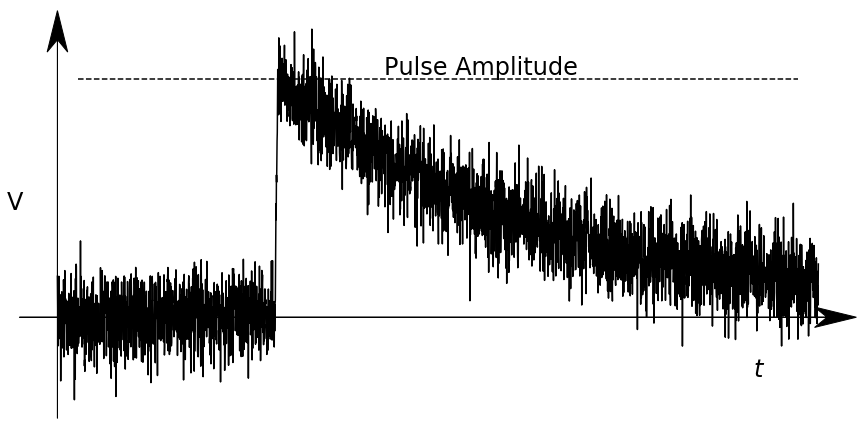

In [6]:
fig, ax = plt.subplots(figsize=(15,7.5))
ax.plot(wf, color='black')
ax.tick_params(axis='both', reset=True, which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
for a in ax.spines.values():
    a.set_visible(False)

    
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
ax.arrow(xmin, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False) 

ax.arrow(0, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

plt.plot((yhw,len(wf)-yhw), (100, 100), linestyle='--', color='black')
ax.annotate('Pulse Amplitude', xy=(1500,102))
ax.annotate('$t$', xy=(3200, -25))
plt.ylabel('V', rotation='horizontal')
plt.savefig('./plots/wf_example.png', bbox_inches='tight', pad_inches=0)

## Filter Generation

In [7]:
@jit(nopython=True, parallel=True, nogil=True)
def fft_trapezoid(rise_time, flat_top , tau=1250):
    length = wavelen
    length = length+2*rise_time+flat_top;
    p = np.zeros(length)
    s = np.zeros(length)
    input2 = np.zeros(length)
    p[0] = 0.
    s[0] = 0.
    input2[0] = 0.;
    for i in range(1,length):
        input2[i] = s[i] = 0.;
    input2[1]=1.;
    tau = 1/(np.exp(1./tau)-1);
    for i in range(1,length):
        if i>=2*rise_time+flat_top:
            d = input2[i]-input2[i-rise_time]-input2[i-rise_time-flat_top]+input2[i-2*rise_time-flat_top]
        else:
            if i>=rise_time+flat_top:
                d = input2[i]-input2[i-rise_time]-input2[i-rise_time-flat_top]
            else:
                if i>=rise_time:
                    d = input2[i]-input2[i-rise_time]
                else:
                    d = input2[i];
        p[i] = p[i-1]+d;
        s[i] = s[i-1]+p[i]+tau*d;
    for i in range(length):
        s[i] = s[i]/(rise_time*tau);
    return s[:-(2*rise_time+flat_top)]

In [8]:
r = fft_trapezoid(100, 10)

In [9]:
%%cython
from libc.stdlib cimport malloc, free
cimport numpy as np
import numpy as np
np.import_array()

def fft_cusp(int rise_time, int flat_top, double tau=1250):
    
    cdef:

        int i;
        int wavelen=3500;
            
        short* inputWF = <short*> malloc(wavelen*sizeof(short));

        
        int filter_length = 2*rise_time+flat_top;
#        double *out = <double*>malloc(wavelen*sizeof(double)) #new double[wavelen];
        double *p0_1 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #0th-order polynomial, segment 1
        double *p1_1 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #1st-order polynomial, segment 1
        double *p2_1 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #2nd-order polynomial, segment 1
        double *p0_2 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #0th-order polynomial, segment 2
        double *p0_3 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #0th-order polynomial, segment 3
        double *p1_3 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #1st-order polynomial, segment 3
        double *p2_3 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #2nd-order polynomial, segment 3
        double c0_1 = 0.5*(tau-0.5); #coefficient for p0_1
        double c1_1 = (tau-0.5); #coefficient for p1_1
        double c2_1 = 1.; #coefficient for p2_1
        double c0_2 = 0.5*rise_time*(rise_time+1.); #coefficient for p0_2
        double c0_3 = .5*(rise_time+rise_time*rise_time-(tau-0.5)-2.*rise_time*(tau-0.5)); #coefficient for p0_3
        double c1_3 = -1.-rise_time+(tau-0.5); #coefficient for p1_3
        double c2_3 = 1.; #coefficient for p2_3
    
    out = np.empty(wavelen+filter_length, dtype=np.float64)

    for i in range(1,wavelen):
        inputWF[i] = 0;
        inputWF[0] = 1;
    
    for i in range(filter_length): #(int i=0; i<filter_length; i++):
    
        p0_1[i] = p1_1[i] = p2_1[i] = p0_2[i] = p0_3[i] = p1_3[i] = p2_3[i] = 0.;
    
    for i in range(wavelen): #(int i=0; i<length; i++):

        p0_1[i+filter_length] = p0_1[i+filter_length-1] + inputWF[i] - (inputWF[i-rise_time] if i>=rise_time else 0);

        p1_1[i+filter_length] = p1_1[i+filter_length-1] + p0_1[i+filter_length] - (rise_time*inputWF[i-rise_time] if i>=rise_time else 0);
        p2_1[i+filter_length] = p2_1[i+filter_length-1] + p1_1[i+filter_length] - (0.5*rise_time*(rise_time+1)*inputWF[i-rise_time] if i>=rise_time else 0);

        p0_2[i+filter_length] = p0_2[i+filter_length-1] + (inputWF[i-rise_time] if i>=rise_time else 0) - (inputWF[i-rise_time-flat_top] if i>=(rise_time+flat_top) else 0);

        p0_3[i+filter_length] = p0_3[i+filter_length-1] + (inputWF[i-rise_time-flat_top] if i>=(rise_time+flat_top) else 0) - (inputWF[i-filter_length] if i>=filter_length else 0);
        p1_3[i+filter_length] = p1_3[i+filter_length-1] + p0_3[i+filter_length] - (rise_time*inputWF[i-filter_length] if i>=filter_length else 0);
        p2_3[i+filter_length] = p2_3[i+filter_length-1] + p1_3[i+filter_length] - (.5*rise_time*(rise_time+1)*inputWF[i-filter_length] if i>=filter_length else 0);

        out[i] = (c0_1*p0_1[i+filter_length]+c1_1*p1_1[i+filter_length]+c2_1*p2_1[i+filter_length]+c0_2*p0_2[i+filter_length]+c0_3*p0_3[i+filter_length]+c1_3*p1_3[i+filter_length]+c2_3*p2_3[i+filter_length])/(.5*rise_time*(rise_time+1.)*(tau-0.5));

    free(p0_1);
    free(p1_1);
    free(p2_1);
    free(p0_2);
    free(p0_3);
    free(p1_3);
    free(p2_3);

    return out[:-(flat_top+2*rise_time)];

In [10]:
def getFilter(name, params):
    FilterDict = {'trap':fft_trapezoid, 'cusp_top':fft_cusp}
    return np.fft.rfft(FilterDict[name](*params))

In [11]:
f = getFilter('trap', (200,100))

In [12]:
wf = dataGen(100,1000) + np.random.normal(scale=20, size=3500)

In [13]:
wf = np.fft.irfft(np.fft.rfft(wf)*f)

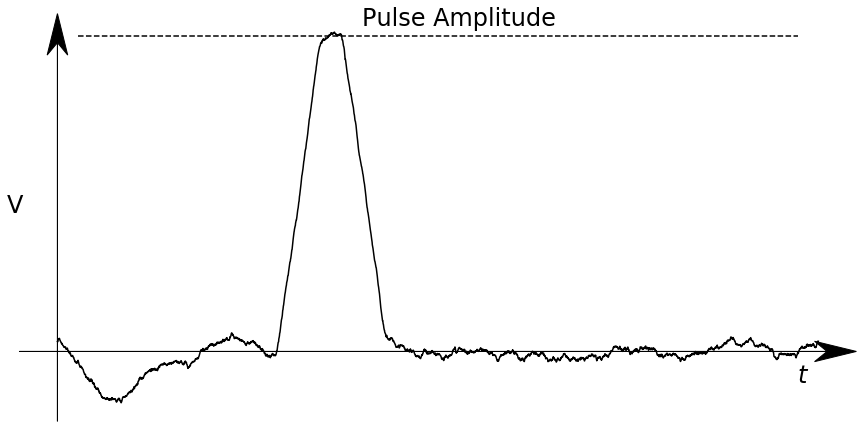

In [14]:
fig, ax = plt.subplots(figsize=(15,7.5))
ax.plot(wf, color='black')
ax.tick_params(axis='both', reset=True, which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
for a in ax.spines.values():
    a.set_visible(False)

    
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
ax.arrow(xmin, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False) 

ax.arrow(0, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

plt.plot((yhw,len(wf)-yhw), (100, 100), linestyle='--', color='black')
ax.annotate('Pulse Amplitude', xy=(1400,103))

plt.ylabel('V', rotation='horizontal')
ax.annotate('$t$', xy=(3400, -10))
#plt.xlabel('Trapezoid Filter');
plt.savefig('./plots/trap_example.png', bbox_inches='tight', pad_inches=0)

In [15]:
wf = dataGen(100,1000) + np.random.normal(scale=20, size=3500)

In [16]:
f = getFilter('cusp_top',(200,100))

In [17]:
wf = np.fft.irfft(np.fft.rfft(wf)*f)

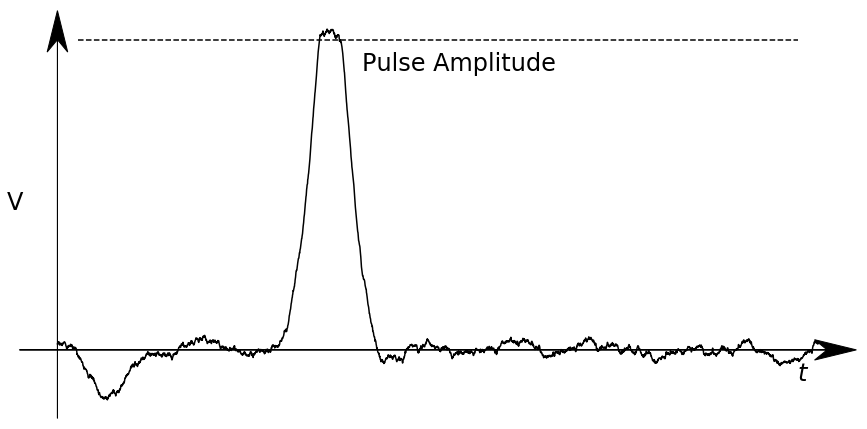

In [18]:
fig, ax = plt.subplots(figsize=(15,7.5))
ax.plot(wf, color='black')
ax.tick_params(axis='both', reset=True, which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
for a in ax.spines.values():
    a.set_visible(False)

    
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
ax.arrow(xmin, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False) 

ax.arrow(0, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

plt.plot((yhw,len(wf)-yhw), (100, 100), linestyle='--', color='black')
ax.annotate('Pulse Amplitude', xy=(1400,90))

plt.ylabel('V', rotation='horizontal')
ax.annotate('$t$', xy=(3400, -10))
#plt.xlabel('Cusp Filter');
plt.savefig('./plots/cusp_example.png', bbox_inches='tight', pad_inches=0)

### MWD based methods
Format algName(waveforms, arguments - expect 3)

In [19]:
wf = dataGen(100,1000) + np.random.normal(scale=2.5, size=wavelen)

In [20]:
f = getFilter('trap', [200,100,1250])

In [21]:
def thresholdingPlot(wf, f, args):
    res = np.fft.irfft(np.fft.rfft(wf)*f)
    
    # plot and label the original waveform
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(wf, color='black')
    plt.title('Thresholding Method with Trapezoidal Filter')
    ax.annotate('(a) Original Waveform', xy=(1900, 60), 
                xytext=(60, 10), textcoords='offset points', va='center',
                arrowprops=dict(arrowstyle='->'))
    
    ax.tick_params(axis='both', reset=True, which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    for a in ax.spines.values():
        a.set_visible(False)
    
    # plot the filtered waveform
    plt.plot(res, color='black')
    ax.annotate('(b) Filtered Waveform', xy=(2000, 2), 
                xytext=(0, 30), textcoords='offset points', va='center',
                arrowprops=dict(arrowstyle='->'))
 
    PERCENT, RISE, TOP = args
    
    maxVal = np.amax(res)*PERCENT
    
    # label maximum
    ax.annotate('(c) Maximum Value', xy=(np.argmax(res), np.amax(res)), 
                xytext=(50, -30), textcoords='offset points', va='center',
                arrowprops=dict(arrowstyle='->'))
 
    
    crossing1 = -1; crossing2 = -1
    for i in range(800,wavelen-1):
        if (res[i]<maxVal and res[i+1] >= maxVal):
            crossing1 = i
            break
    for i in range(int(crossing1+TOP/2),wavelen-1):
        if (res[i]>maxVal and res[i+1] <= maxVal):
            crossing2 = i
            break

    ax.annotate(r'(d) $1^{st}$ Crossing', xy=(crossing1, res[crossing1]), 
                xytext=(-250, 30), textcoords='offset points', va='center',
                arrowprops=dict(arrowstyle='->'))
    ax.annotate(r'(e) $2^{nd}$ Crossing', xy=(crossing2, res[crossing2]), 
                xytext=(25, -100), textcoords='offset points', va='center',
                arrowprops=dict(arrowstyle='->'))

    t0 = (crossing1+crossing2)/2 - RISE - TOP/2

    plt.arrow(crossing1, res[crossing1], -(crossing1-crossing2)/2-36, 0, color='black', fill=False, length_includes_head=True, head_width=6, overhang=5)
    plt.arrow(crossing2, res[crossing2], (crossing1-crossing2)/2 +36, 0, color='black', fill=False, length_includes_head=True, head_width=6, overhang=5)

    ax.annotate(r'(f) $t_0$', xy=(t0+RISE+TOP/2, res[crossing1]), 
                xytext=(-30, -100), textcoords='offset points', va='center',
                arrowprops=dict(arrowstyle='->'))
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.margins(0,0)
    plt.gca().set_axis_off()
    plt.savefig('./plots/trap_threshold.png', bbox_inches='tight', pad_inches=0)
    return t0#, res[int((crossing1+crossing2)/2)]

1006.0

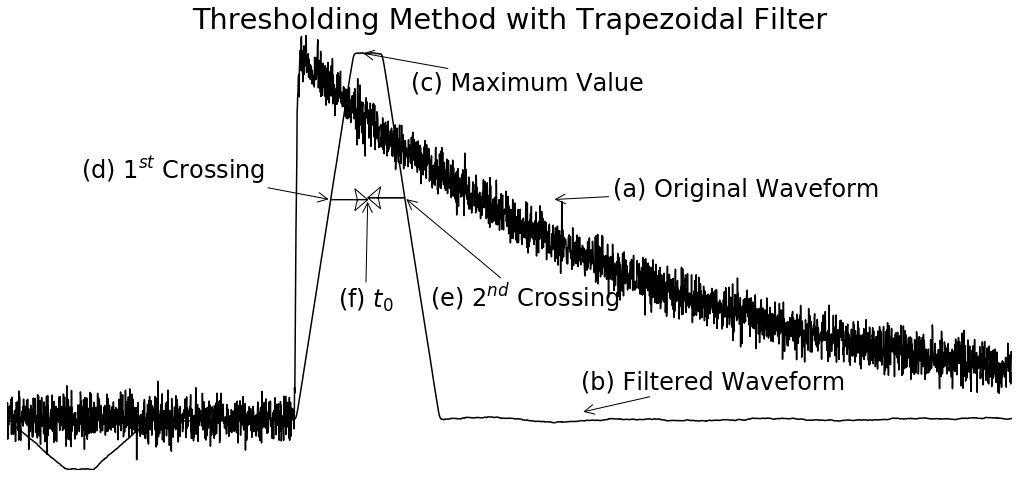

In [22]:
thresholdingPlot(wf+np.random.normal(scale=2, size=wavelen), f, (0.6, 200., 100.))

In [23]:
f = getFilter('trap', (200,100))

In [24]:
def edgeLS(res, args):
    
    

    rise, top = args
    # find range to look for
    s = scipy.signal.savgol_filter(res,3,1,deriv=1)
    expected_slope = (np.amax(res)-np.std(res))/(rise)
    std_s = np.std(s[:-100])
    
    fig, ax = plt.subplots(nrows=3, figsize=(25,8))
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.gca().set_axis_off()

    ax[0].plot(wf, color='black')

    ax[1].plot(res, color='black')
    
    ax[2].plot(s, color='black')

    for axl in ax:
        axl.tick_params(axis='both', reset=True, which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        for a in axl.spines.values():
            a.set_visible(False)
        ymin, ymax = axl.get_ylim()
        xmin, xmax = axl.get_xlim() 
     
    fall_range = [i for i in range(len(s)) if s[i]< -0.5*expected_slope]
    fall_range = np.arange(3500)[fall_range[0]:fall_range[-1]]
    
    a2, b2 = np.polyfit(fall_range, res[fall_range[0]:fall_range[-1]+1], 1) #LS(fall_range,res)
    
    t0 = -b2/a2 - 2*rise - top 
    
    ax[0].annotate('(a) Original Waveform', xy=(1050, 10), va='center')
    
    ax[1].annotate('(b) Trapezoidal Filtered Waveform', xy=(1550, 10))

    ax[2].annotate('(c) Savitzky-Golay Filtered Waveform', xy=(1800, .15))

    ax[2].plot((1200,1600), (-0.5*expected_slope, -0.5*expected_slope), linestyle='--', color='black')
    
    ax[1].plot((fall_range[0],fall_range[0]), (0,110), linestyle='--', color='black')
    ax[1].plot((fall_range[-1],fall_range[-1]), (0,110), linestyle='--', color='black')
    

    ax[2].annotate(r'(d) $-\frac{1}{2}*\frac{Maximum}{Rise Length}$', xy=(650, -.3))

    ax[1].annotate('(e) Linear Fit Region', xy=(1400,50), 
                xytext=(-400, 0), textcoords='offset points', va='center',
                arrowprops=dict(arrowstyle='->'))
    
    plt.savefig('./plots/trap_edgeLS.png', bbox_inches='tight', pad_inches=0)

    return t0

1096.9685763264708

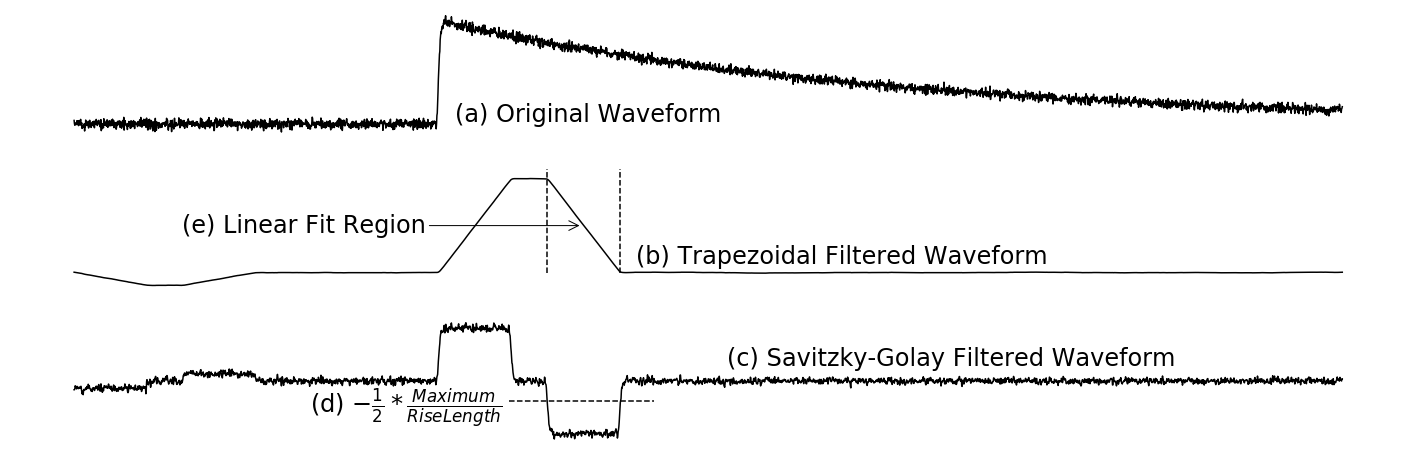

In [25]:
edgeLS(np.fft.irfft(np.fft.rfft(wf)*f), (200, 10))

In [26]:
def meanSlope(res, args):
    rise, top = args
    # find range to look for
    s = scipy.signal.savgol_filter(res,5,1,deriv=1)
    expected_slope = np.amax(res)/(rise-5)
    std_s = np.std(s[:-100])
    
    # fit to rise and fall
    left_shoulder = [i for i in range(len(s)) if s[i] > expected_slope-std_s]
    right_shoulder = [i for i in range(len(s)) if s[i]< -expected_slope+std_s]
    t0 = (np.mean(left_shoulder)+np.mean(right_shoulder))/2 - rise - top/2

        
    fig, ax = plt.subplots(nrows=3, figsize=(25,8))
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.gca().set_axis_off()

    ax[0].plot(wf, color='black')

    ax[1].plot(res, color='black')
    
    ax[2].plot(s, color='black')

    for axl in ax:
        axl.tick_params(axis='both', reset=True, which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        for a in axl.spines.values():
            a.set_visible(False)
        ymin, ymax = axl.get_ylim()
        xmin, xmax = axl.get_xlim() 
        
    ax[0].annotate('(a) Original Waveform', xy=(1050, 10), va='center')
    
    ax[1].annotate('(b) Trapezoidal Filtered Waveform', xy=(1550, 10))

    ax[2].annotate('(c) Savitzky-Golay Filtered Waveform', xy=(1800, .15))

    ax[2].plot((1200,1600), (-0.5*expected_slope, -0.5*expected_slope), linestyle='--', color='black')
    ax[2].annotate(r'(e) $-\frac{1}{2}*\frac{Maximum}{Rise Length}$', xy=(650, -.3))
    
    ax[2].plot((900,1250), (0.5*expected_slope, 0.5*expected_slope), linestyle='--', color='black')
    ax[2].annotate(r'(d) $\frac{1}{2}*\frac{Maximum}{Rise Length}$', xy=(400, .25))

    
    plt.savefig('./plots/trap_meanSlope.png', bbox_inches='tight', pad_inches=0)

    return t0

1051.5

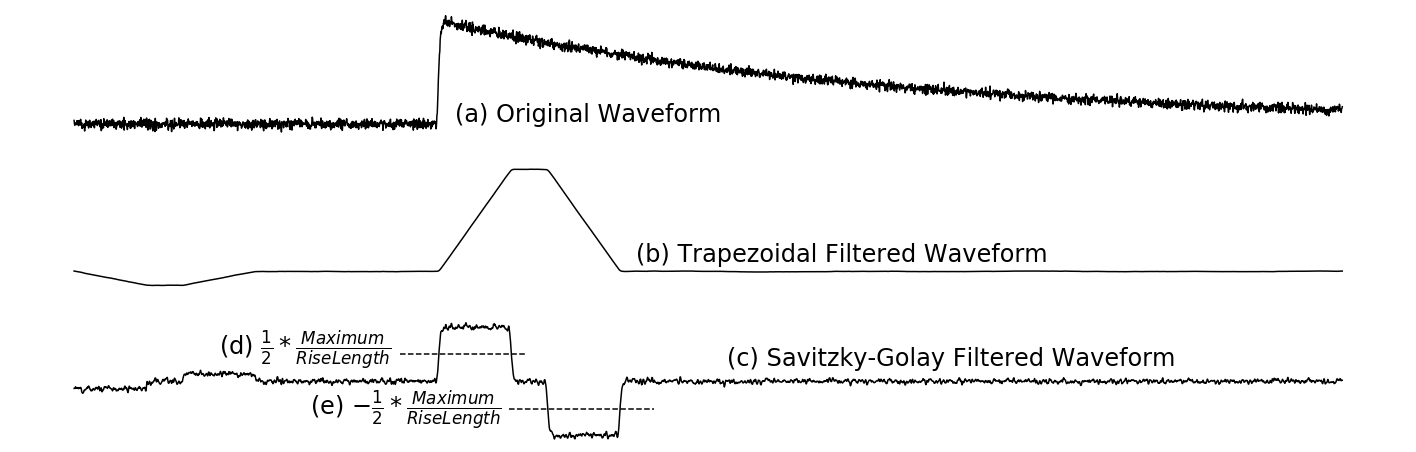

In [27]:
meanSlope(np.fft.irfft(np.fft.rfft(wf)*f), (200, 10))

In [28]:
def shoulders(res, args): 
    rise, top = args
    # find range to look for
    s = scipy.signal.savgol_filter(res,5,1,deriv=1)
    expected_slope = np.amax(res)/(rise-5)
    std_s = np.std(s[:-100])
    
    # fit to rise and fall
    left_shoulder = [i for i in range(len(s)-2) if s[i] > expected_slope*0.5 and s[i+1] < expected_slope*0.5]
    right_shoulder = [i for i in range(len(s)-2) if s[i] < expected_slope*0.5 and s[i+1] > expected_slope*0.5]

    t0 = (np.mean(left_shoulder)+np.mean(right_shoulder))/2 - rise/2 - top/2

    fig, ax = plt.subplots(nrows=3, figsize=(25,8))
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.gca().set_axis_off()

    ax[0].plot(wf, color='black')

    ax[1].plot(res, color='black')
    
    ax[2].plot(s, color='black')

    for axl in ax:
        axl.tick_params(axis='both', reset=True, which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        for a in axl.spines.values():
            a.set_visible(False)
        ymin, ymax = axl.get_ylim()
        xmin, xmax = axl.get_xlim() 
        
    ax[0].annotate('(a) Original Waveform', xy=(1050, 10), va='center')
    
    ax[1].annotate('(b) Trapezoidal Filtered Waveform', xy=(1550, 10))

    ax[2].annotate('(c) Savitzky-Golay Filtered Waveform', xy=(1800, .15))

    c = Ellipse((np.mean(left_shoulder),s[int(np.mean(left_shoulder))]), width=50, height=.2, fill=False, color='black')
    ax[2].add_patch(c)
    ax[2].annotate('(d) Rising Edge Crossing', xy=(150,.2))

    c = Ellipse((np.mean(right_shoulder),s[int(np.mean(right_shoulder))]), width=50, height=.2, fill=False, color='black')
    ax[2].add_patch(c) 
    ax[2].annotate('(e) Corner Crossing', xy=(np.mean(left_shoulder),s[int(np.mean(left_shoulder))]), 
                xytext=(-200, -60), textcoords='offset points', va='center',
                arrowprops=dict(arrowstyle='->'))
   
    
    plt.savefig('./plots/trap_shoulders.png', bbox_inches='tight', pad_inches=0)
 
    
    return t0

1001.0

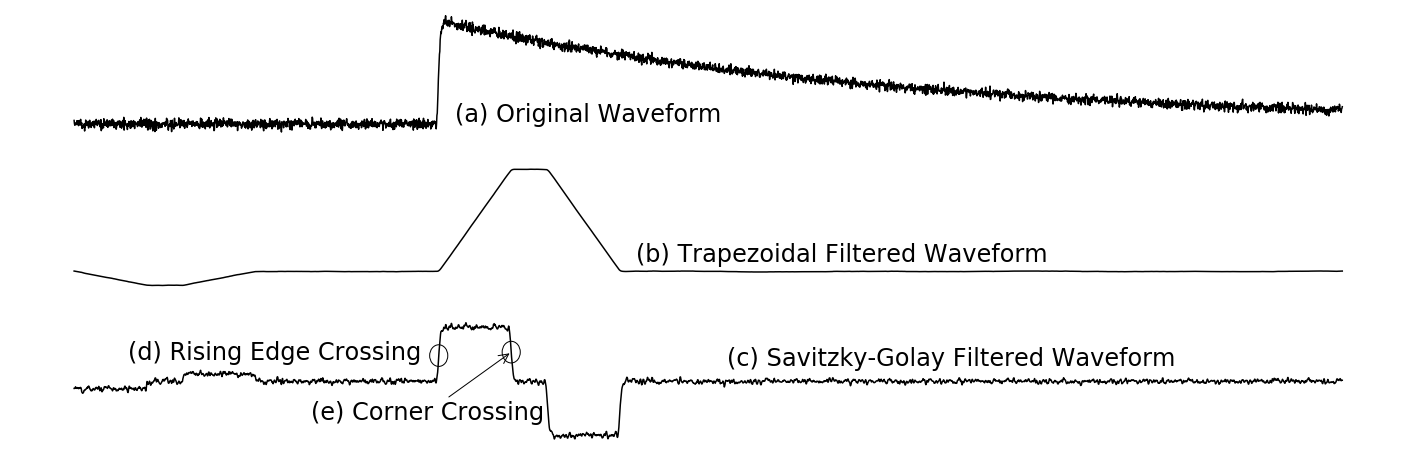

In [29]:
shoulders(np.fft.irfft(np.fft.rfft(wf)*f), (200, 10))